In [37]:
%matplotlib inline

from __future__ import annotations

import math
from typing import Any

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy
import seaborn

from matplotlib.ticker import ScalarFormatter

# to change default colormap
plt.rcParams["image.cmap"] = "tab10"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [38]:
DATA = pandas.read_csv('data/6-federated-learning/federated-learning-results.csv')
DATA = DATA.replace(to_replace={
    "no_store": "Cloud Transfer",
    "proxystore": "EndpointStore"
})
DATA.head()

,round,endpoint_name,transfer_time,data_transfer_size,model_param_size,model_arch_size,local,test_accuracy,test_loss,train_accuracy,train_loss,num_hidden_blocks,store,time_taken_for_process
0,1.0,hawfinch,3.150909,2281716.0,2281615.0,5596.0,False,0.5002,3.525516,0.20,3.525516,1,Cloud Transfer,158.40915
1,1.0,kestrel,4.464043,2281716.0,2281615.0,5596.0,False,0.5002,3.440624,0.24,3.440624,1,Cloud Transfer,158.40915
2,1.0,ryerson,4.977898,2281716.0,2281615.0,5596.0,False,0.5002,3.098623,0.21,3.098623,1,Cloud Transfer,158.40915
3,1.0,jetson,4.599578,2281716.0,2281615.0,5596.0,False,0.5002,3.867584,0.19,3.867584,1,Cloud Transfer,158.40915
4,2.0,hawfinch,3.505748,2281716.0,2281615.0,5596.0,False,0.5511,1.181808,0.59,1.181808,1,Cloud Transfer,158.40915


model_param_size
2281615.0     0.689450
4092898.0     0.690844
6105435.0     0.700276
8117972.0     0.653138
10130509.0    0.696836
12143050.0         NaN
Name: transfer_time, dtype: float64


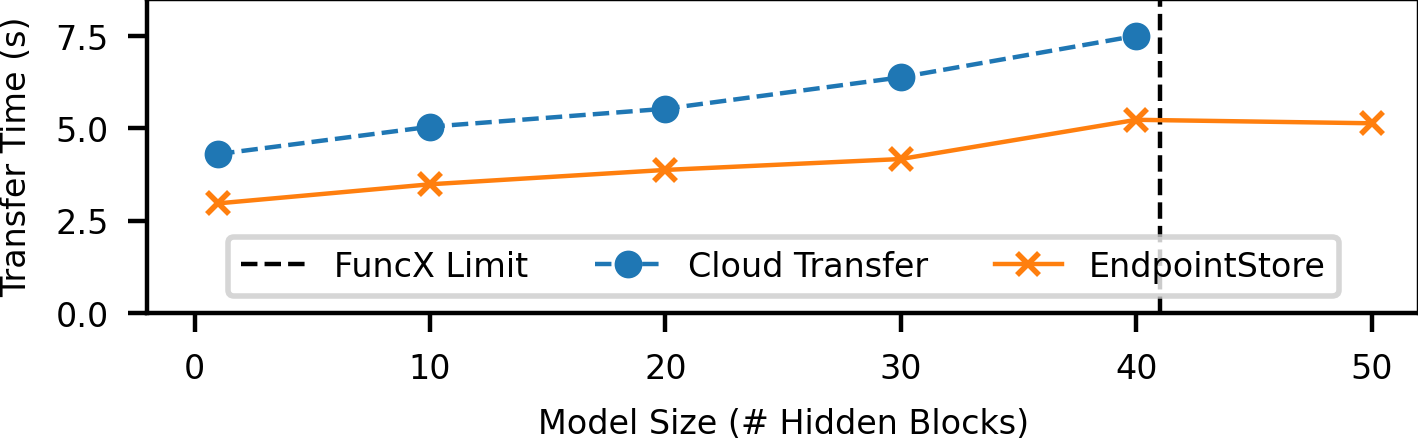

In [71]:
MARKERS = ('o', 'x')
LINES = ('--', '-')
cmap = plt.get_cmap()

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

baseline = DATA[DATA['store'] == 'Cloud Transfer'].copy()
proxystore = DATA[DATA['store'] == 'EndpointStore'].copy()

baseline['x'] = baseline['num_hidden_blocks']
proxystore['x'] = proxystore['num_hidden_blocks']

baseline = baseline.groupby(['model_param_size']).mean(numeric_only=True)
proxystore = proxystore.groupby(['model_param_size']).mean(numeric_only=True)

ax.axvline(41, label="FuncX Limit", color="k", linestyle="--")

print(proxystore['transfer_time'] / baseline['transfer_time'])

for i, (run, data) in enumerate((('Cloud Transfer', baseline), ('EndpointStore', proxystore))):
    ax.plot(
        data['x'],
        data['transfer_time'],
        linestyle=LINES[i],
        marker=MARKERS[i],
        label=run,
    )

ax.set_xlabel('Model Size (# Hidden Blocks)')
ax.set_ylabel('Transfer Time (s)')
ax.set_xlim([-2, 52])
ax.set_ylim([0, 8.5])
ax.legend(loc='lower center', ncols=3)

fig.tight_layout()

fig.set_size_inches(3.5, 0.9)
plt.savefig('figures/federated-learning.pdf', pad_inches=0.05)